In [1]:
import sys
sys.path.insert(0, "../")
from SC_Utils.game_utils import ObsProcesser, get_action_dict
from SC_Utils.train_v2 import *
from SC_Utils.inspection_plots import *
import AC_modules.Networks as net
from AC_modules.BatchedA2C import SpatialA2C, ActionDependentA2C
import torch

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
jump = 120000
n = 10
step_idx =jump*n
step_idx

1200000

In [4]:
# Environment parameters
RESOLUTION = 32
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 
game_names = {1:'MoveToBeacon',
              2:'CollectMineralShards',
              3:'DefeatRoaches',
              4:'FindAndDefeatZerglings',
              5:'DefeatZerglingsAndBanelings',
              6:'CollectMineralsAndGas',
              7:'BuildMarines'
              }
map_name = game_names[2]

# Observation Processer parameters
screen_names = ['visibility_map', 'player_relative', 'selected', 'unit_density', 'unit_density_aa']
minimap_names = []
obs_proc_params = {'screen_names':screen_names, 'minimap_names':minimap_names}
#obs_proc_params = {'select_all':True}
env = init_game(game_params, map_name)
op = ObsProcesser(**obs_proc_params)
screen_channels, minimap_channels = op.get_n_channels()
in_channels = screen_channels + minimap_channels 
#action_names = ['select_point', 'Move_screen']
action_names = ['no_op', 'select_army', 'Attack_screen', 'Move_screen', 'select_point', 'select_rect']
action_dict = get_action_dict(action_names)

In [17]:
PID = "JLJS"#"VYPP"
load=True
if load:
    agent = torch.load("../Results/CollectMineralShards/agent_"+PID, map_location='cpu')
    agent.device = 'cpu'
else:
    action_space = len(action_dict)
    spatial_model = net.FullyConvSpatial
    nonspatial_model = net.FullyConvNonSpatial
    embed_dim = 8
    n_channels = 32
    n_features = 256
    spatial_dict = {"in_channels":in_channels}
    nonspatial_dict = {'resolution':RESOLUTION, 'kernel_size':3, 'stride':2}
    HPs = dict(action_space=action_space, gamma=0.99, n_steps=20, H=1e-3, 
           spatial_model=spatial_model, nonspatial_model=nonspatial_model,
           n_features=n_features, n_channels=n_channels, 
           spatial_dict=spatial_dict, nonspatial_dict=nonspatial_dict, 
           action_dict=action_dict, embed_dim=embed_dim)

    HPs['device'] = 'cpu'
    agent = ActionDependentA2C(env=env, **HPs)

In [18]:
inspector = inspection_test(step_idx, agent, env, PID, op, action_dict)

In [19]:
insp_dict = inspector.dict
insp_dict.keys()

dict_keys(['state_traj', 'rewards', 'action_distr', 'action_sel', 'args', 'values', 'trg_values', 'critic_losses', 'advantages', 'actor_losses', 'queued_distr', 'screen_distr', 'screen2_distr', 'select_add_distr', 'select_point_act_distr'])

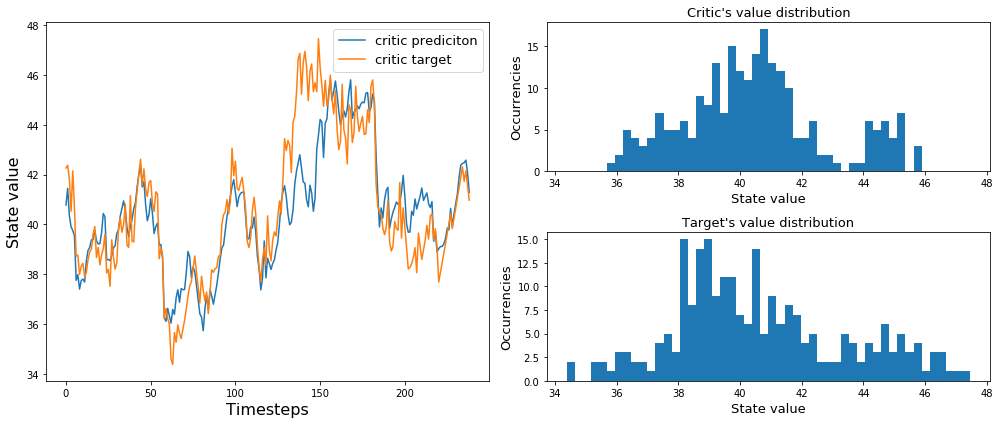

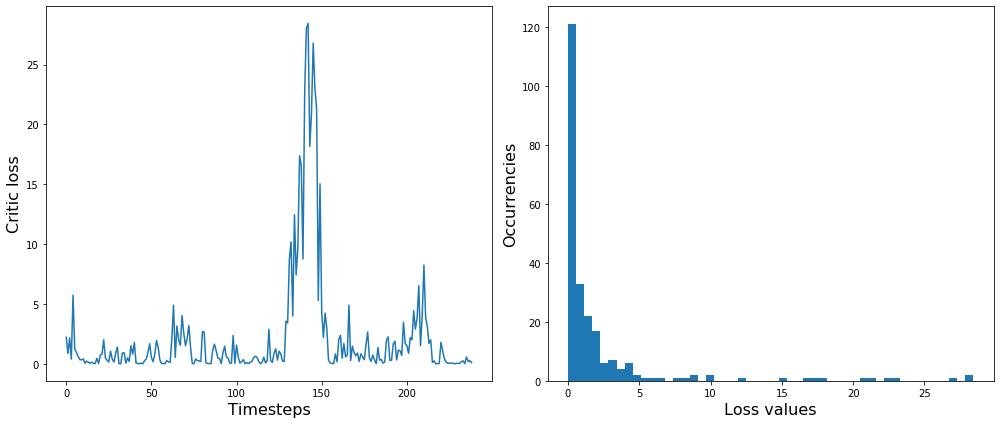

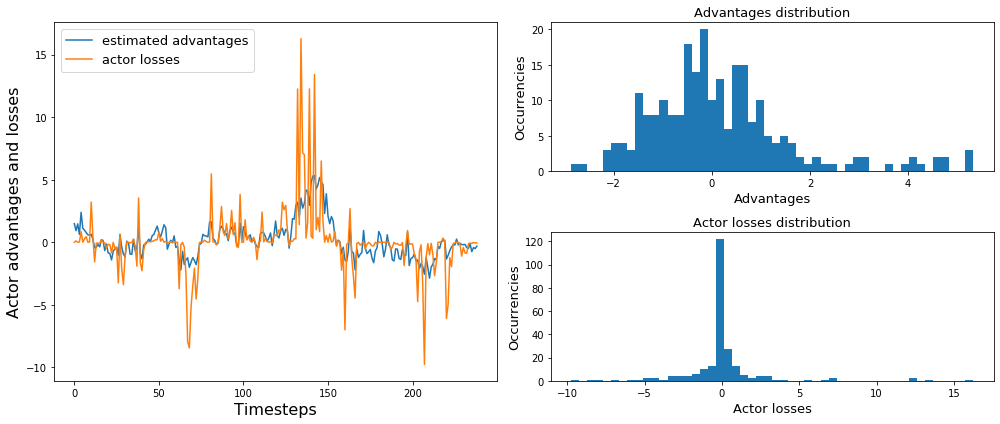

In [20]:
plot_update_curves(insp_dict)

In [21]:
_, layer_names = op.get_state(env.reset())
layer_names

{'screen_names': array(['visibility_map_2', 'player_relative_1', 'player_relative_3',
        'player_relative_4', 'selected_1', 'unit_density',
        'unit_density_aa'], dtype='<U17'),
 'minimap_names': []}


Step 0
Action no_op - prob: 0.00
Action select_army - prob: 1.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 0.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  select_army
Click:  None
Last click:  None


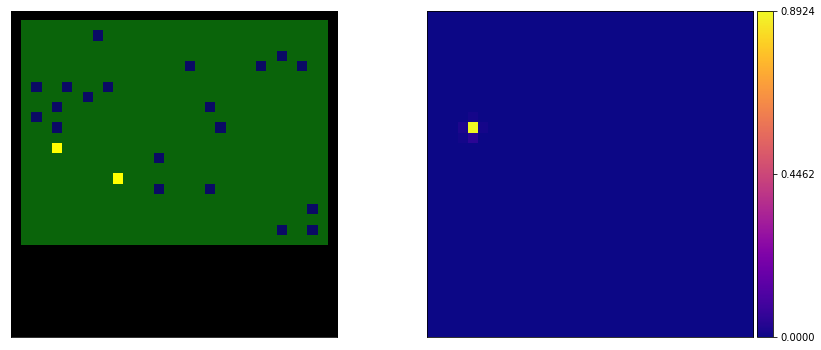


Step 1
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [4, 11]
Last click:  None


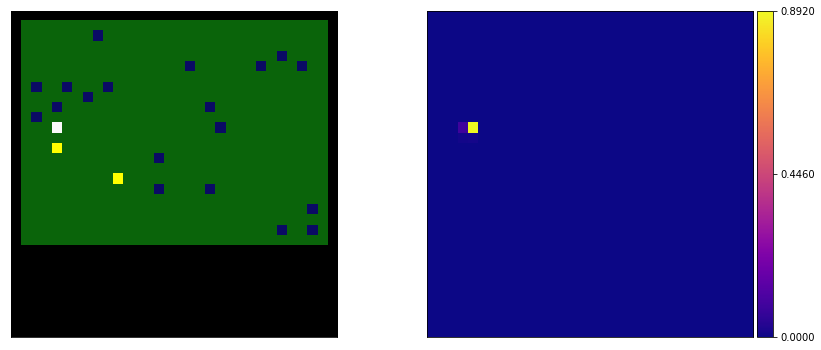


Step 2
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [4, 10]
Last click:  [4, 11]


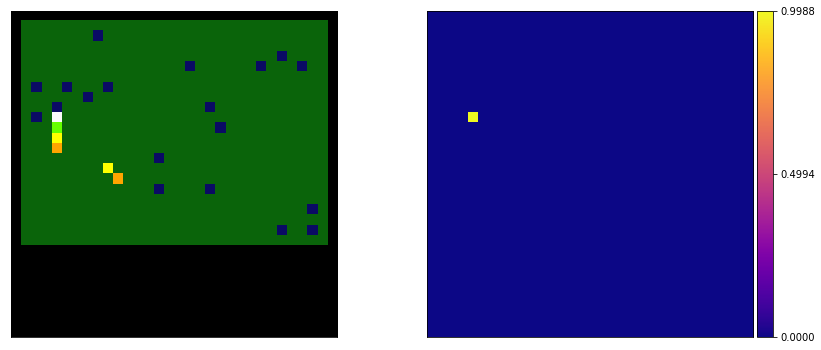


Step 3
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [4, 8]
Last click:  [4, 10]


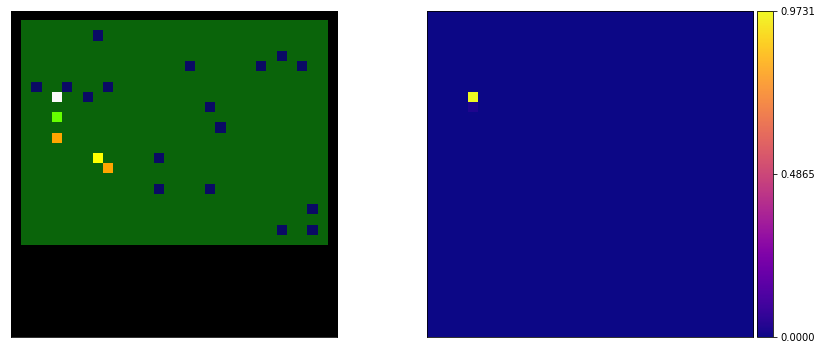


Step 4
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [6, 10]
Last click:  [4, 8]


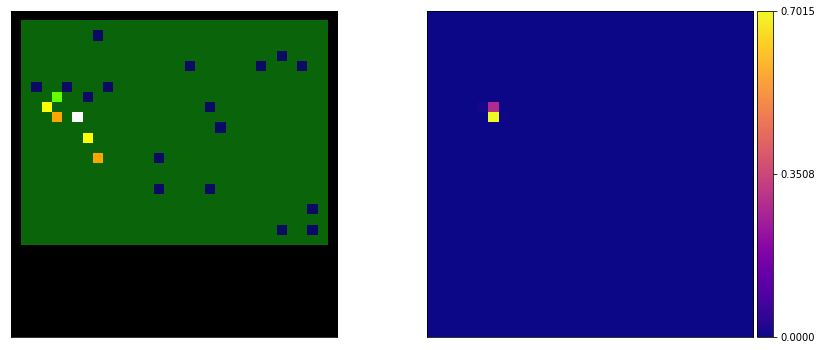


Step 5
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [7, 9]
Last click:  [6, 10]


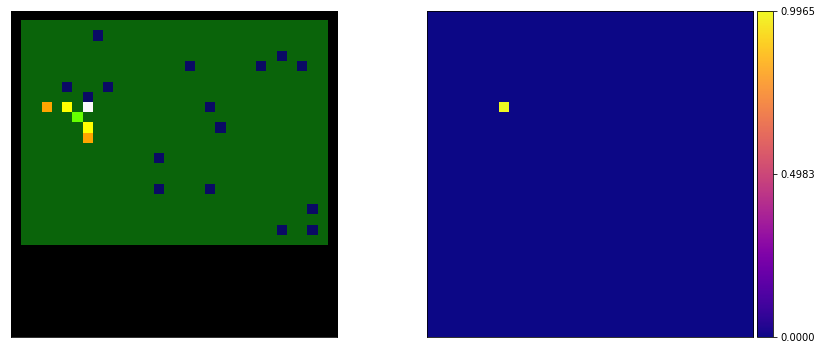


Step 6
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [8, 8]
Last click:  [7, 9]


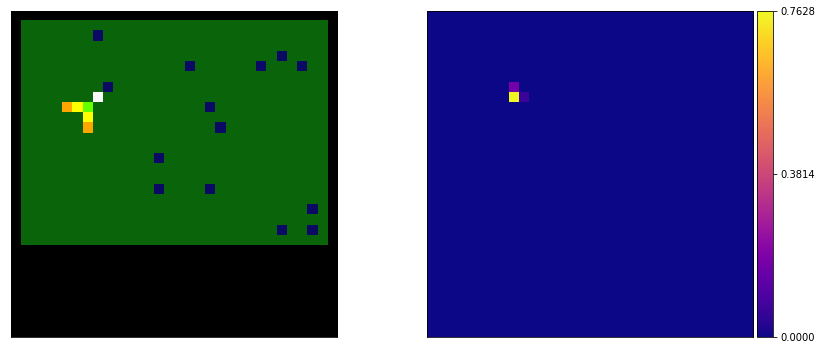


Step 7
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [9, 6]
Last click:  [8, 8]


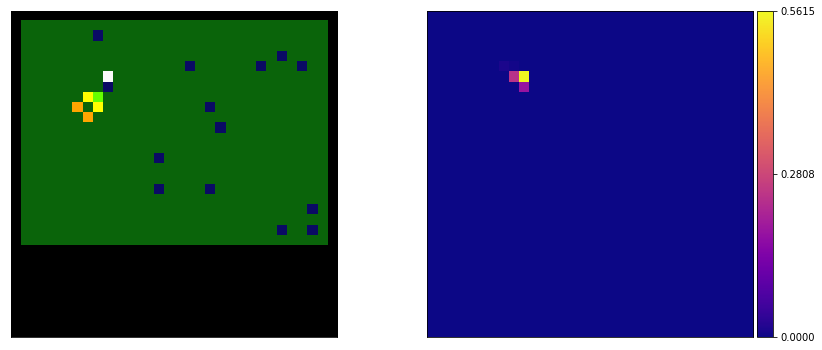


Step 8
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [8, 4]
Last click:  [9, 6]


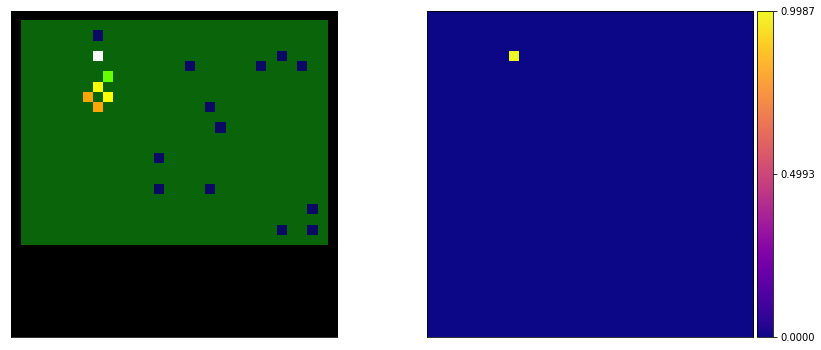


Step 9
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [8, 4]
Last click:  [8, 4]


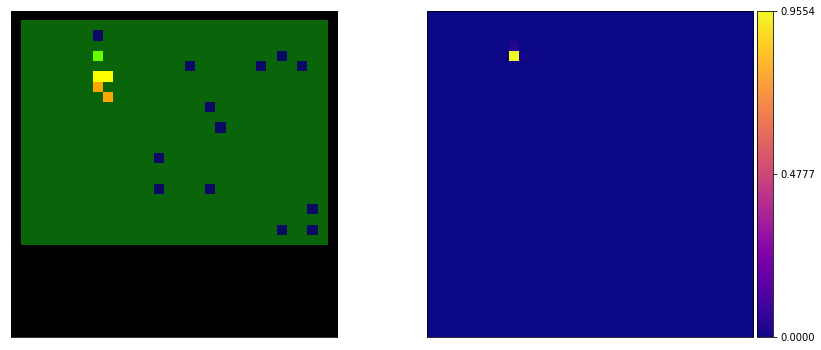


Step 10
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [19, 16]
Last click:  [8, 4]


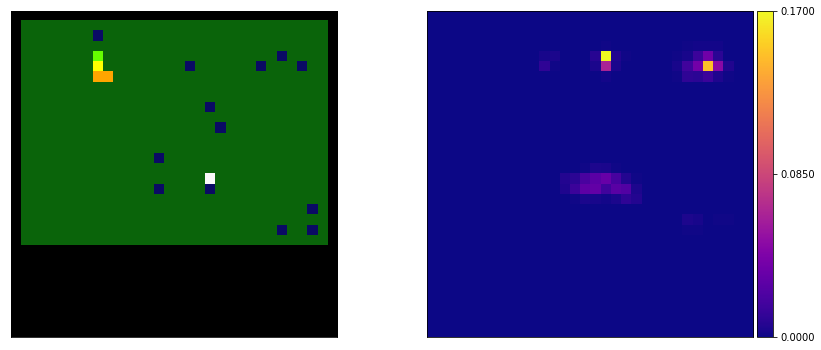


Step 11
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [17, 4]
Last click:  [19, 16]


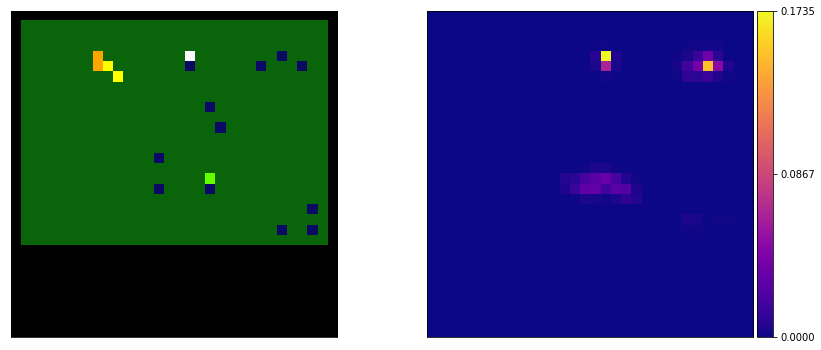


Step 12
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [27, 4]
Last click:  [17, 4]


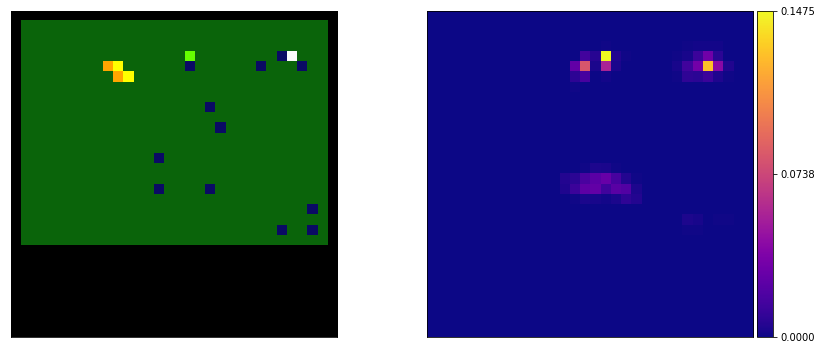


Step 13
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [16, 6]
Last click:  [27, 4]


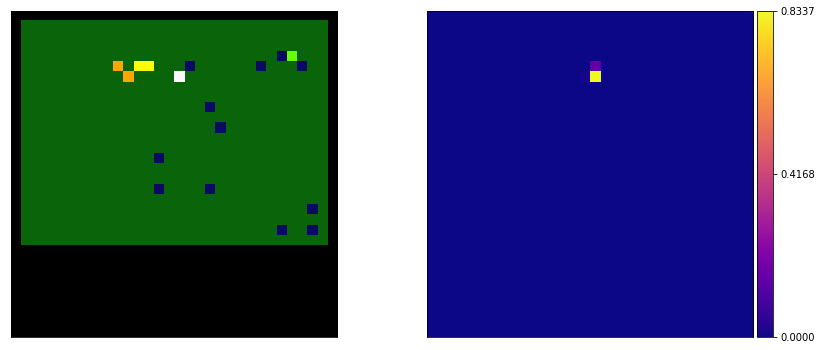


Step 14
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [17, 6]
Last click:  [16, 6]


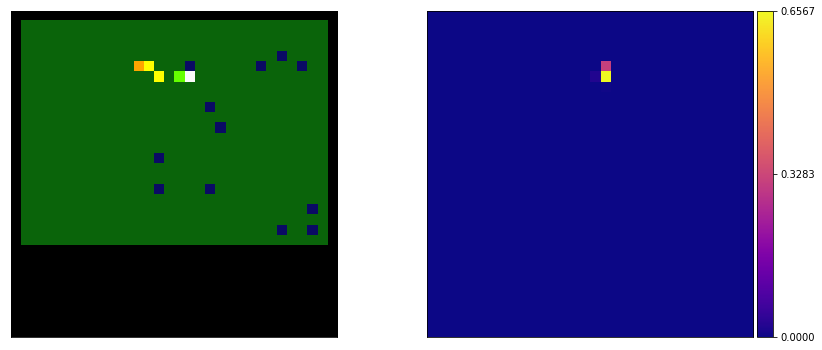


Step 15
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [17, 7]
Last click:  [17, 6]


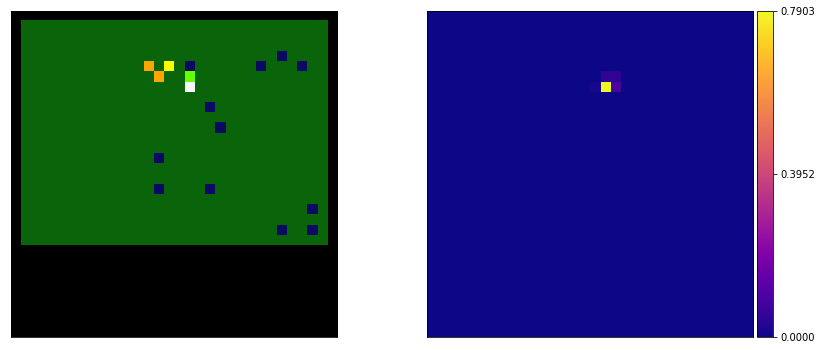


Step 16
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [18, 8]
Last click:  [17, 7]


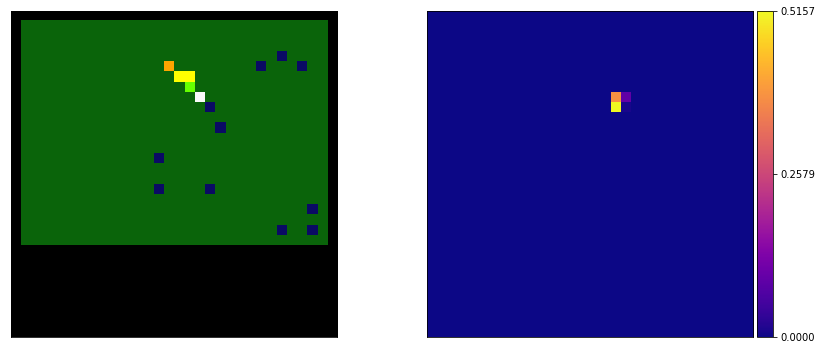


Step 17
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [19, 9]
Last click:  [18, 8]


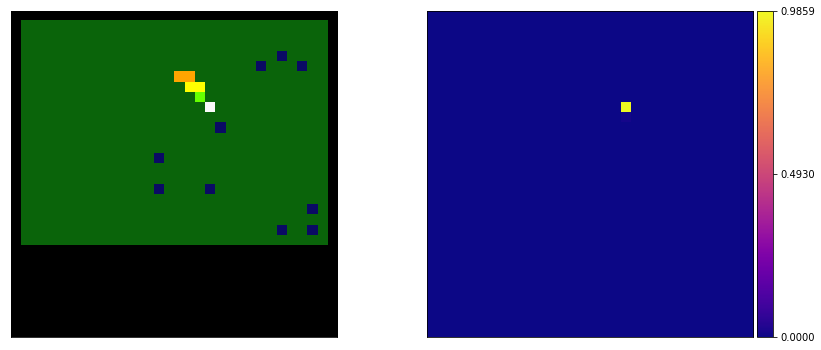


Step 18
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [20, 11]
Last click:  [19, 9]


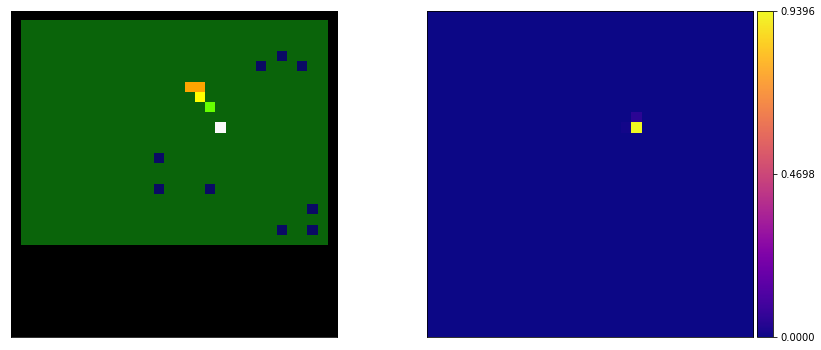


Step 19
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [18, 14]
Last click:  [20, 11]


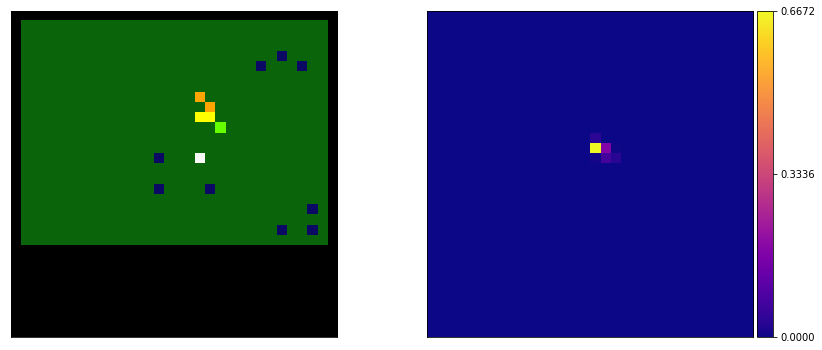


Step 20
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [17, 15]
Last click:  [18, 14]


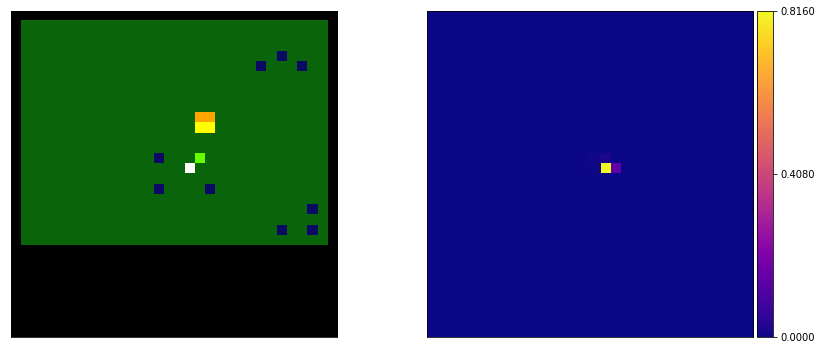


Step 21
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [17, 15]
Last click:  [17, 15]


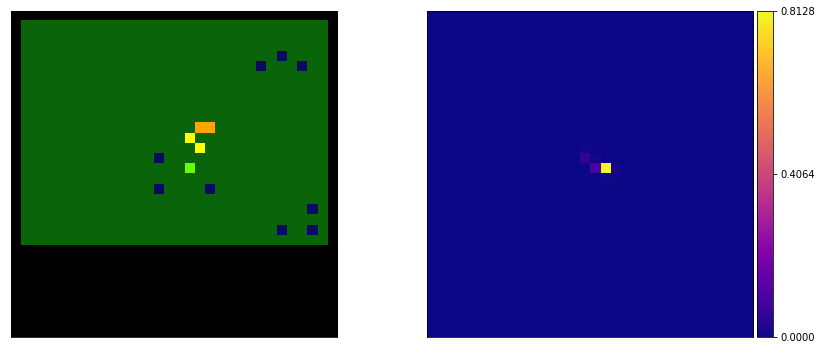


Step 22
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [17, 16]
Last click:  [17, 15]


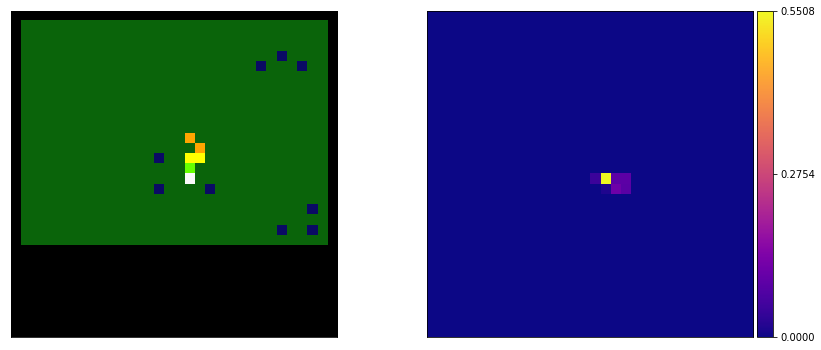


Step 23
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [15, 16]
Last click:  [17, 16]


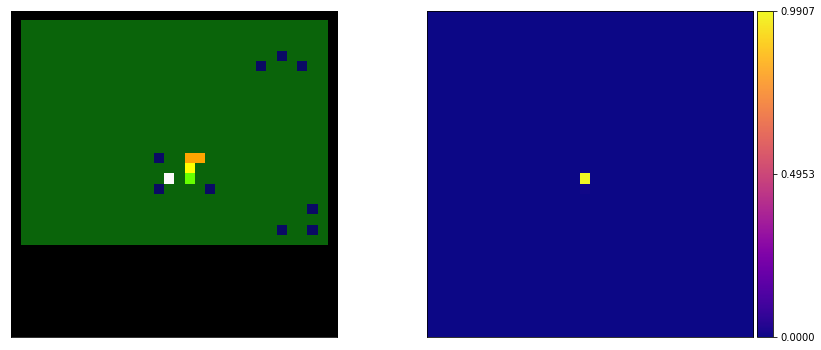


Step 24
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [15, 19]
Last click:  [15, 16]


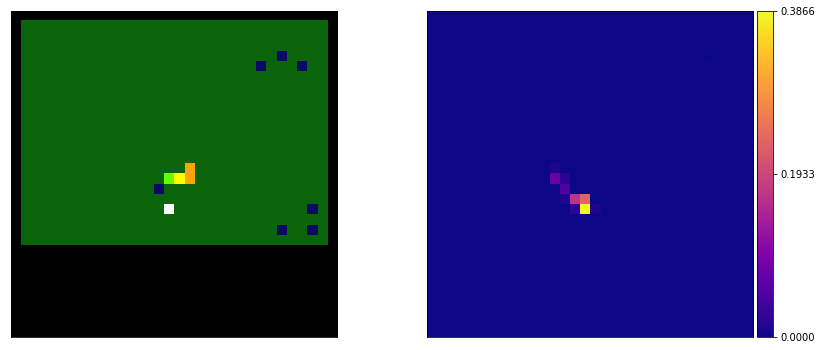


Step 25
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [27, 5]
Last click:  [15, 19]


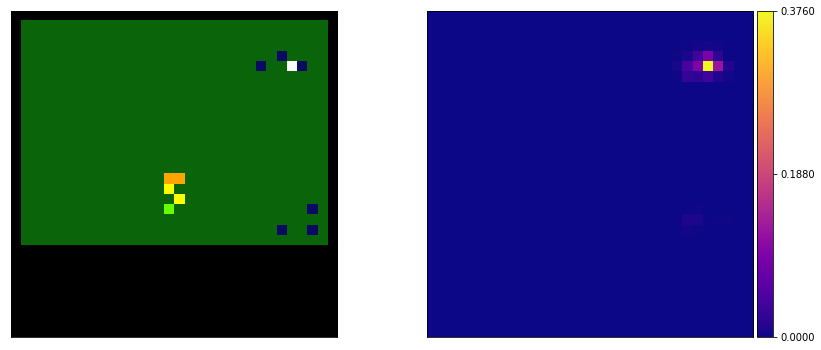


Step 26
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [25, 5]
Last click:  [27, 5]


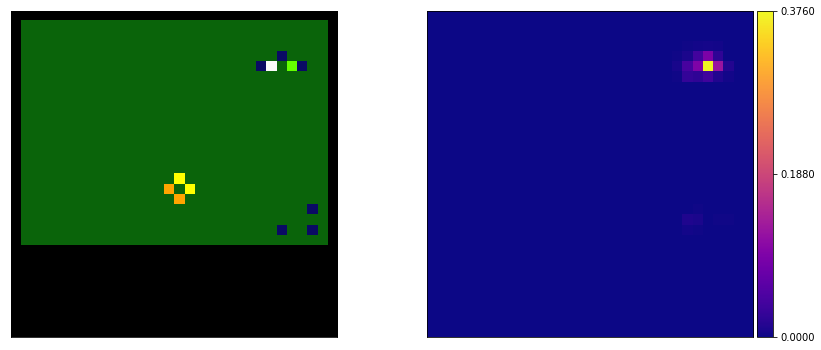


Step 27
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [27, 5]
Last click:  [25, 5]


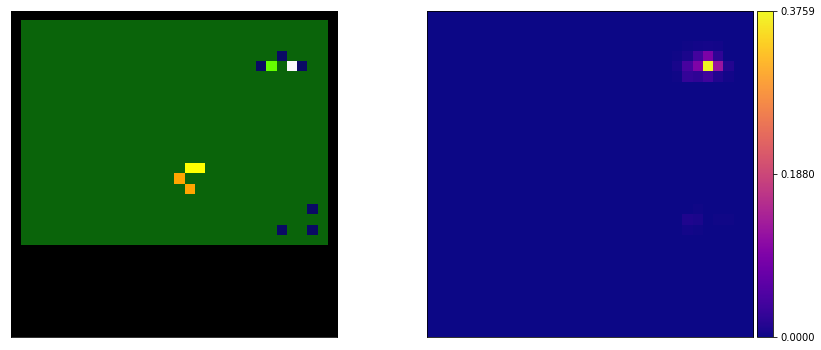


Step 28
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [28, 3]
Last click:  [27, 5]


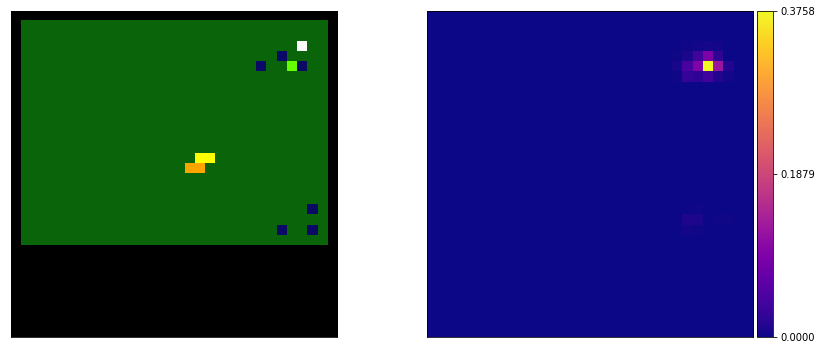


Step 29
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [25, 6]
Last click:  [28, 3]


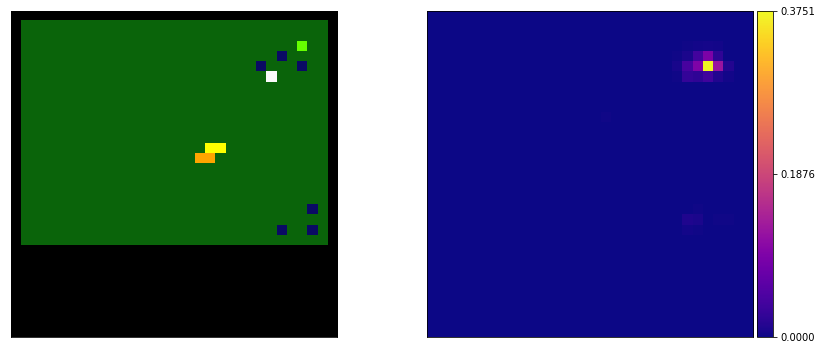


Step 30
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [27, 5]
Last click:  [25, 6]


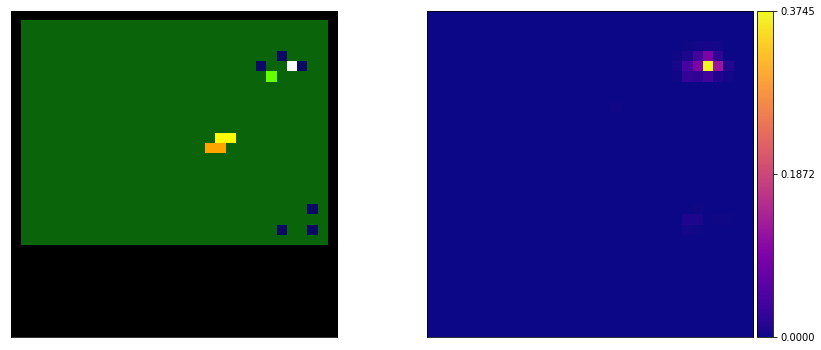


Step 31
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [23, 7]
Last click:  [27, 5]


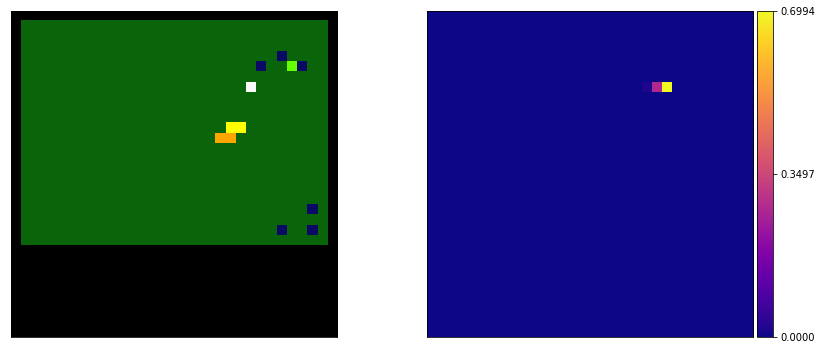


Step 32
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [23, 6]
Last click:  [23, 7]


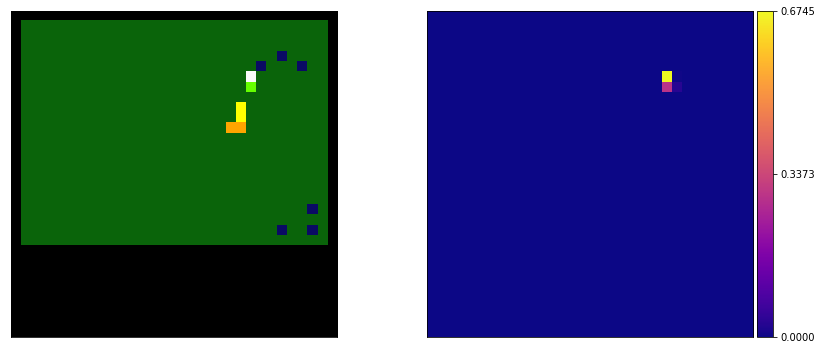


Step 33
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [24, 6]
Last click:  [23, 6]


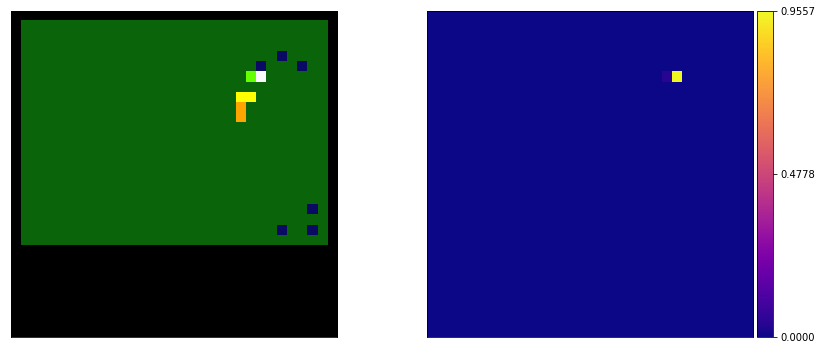


Step 34
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [25, 5]
Last click:  [24, 6]


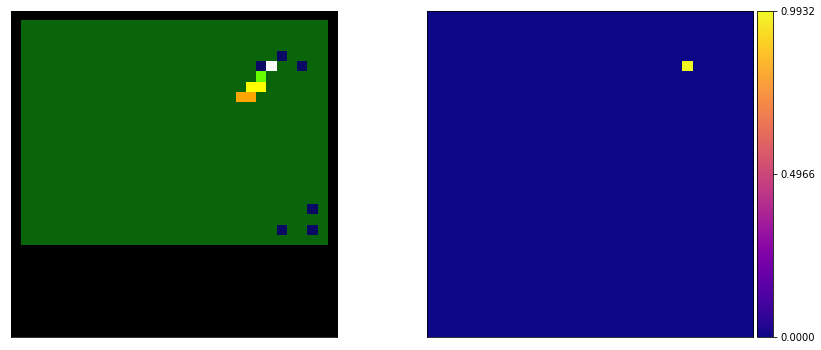


Step 35
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [27, 6]
Last click:  [25, 5]


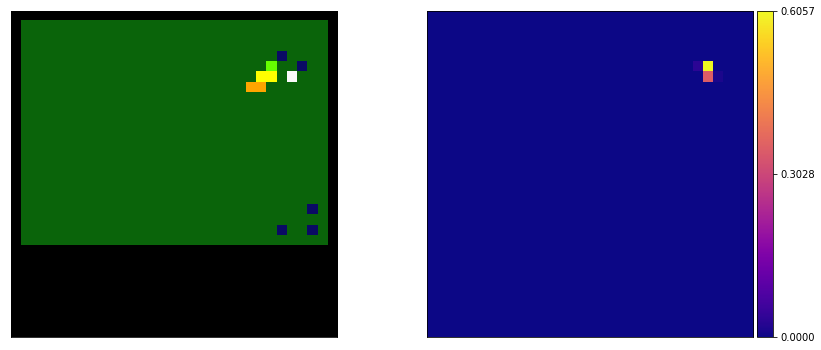


Step 36
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [29, 6]
Last click:  [27, 6]


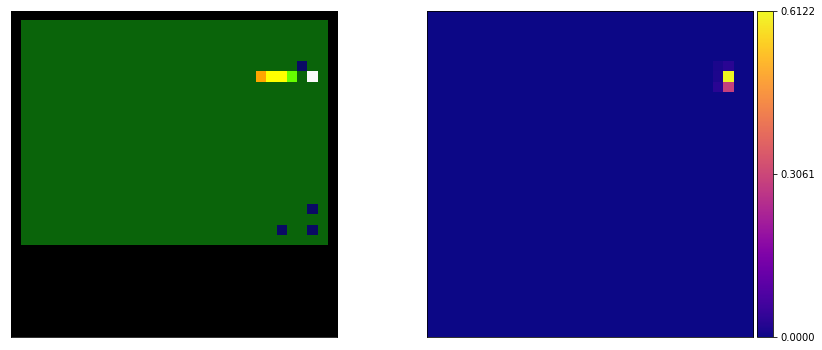


Step 37
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [30, 18]
Last click:  [29, 6]


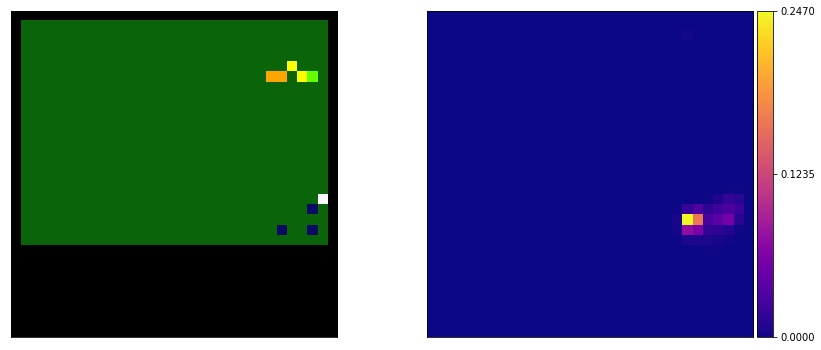


Step 38
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [29, 20]
Last click:  [30, 18]


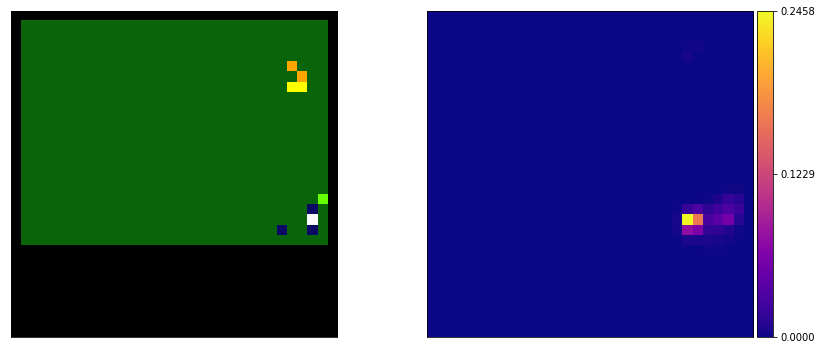


Step 39
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [26, 20]
Last click:  [29, 20]


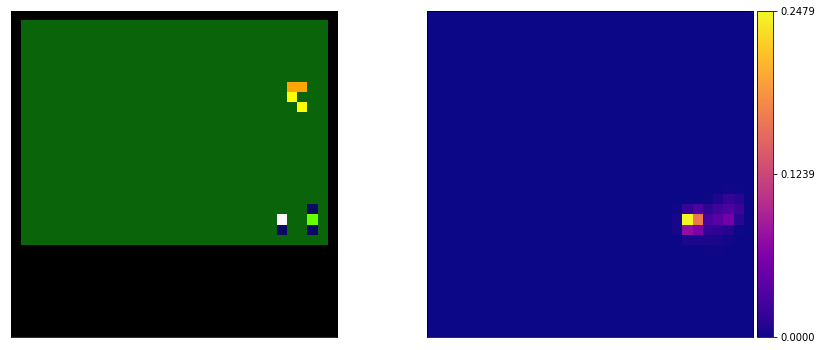


Step 40
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [25, 20]
Last click:  [26, 20]


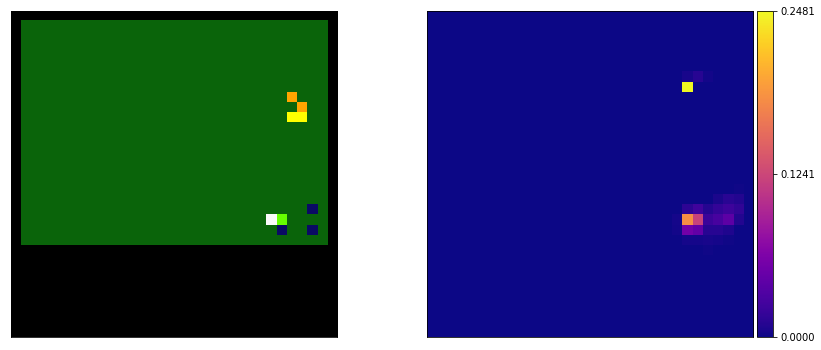


Step 41
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [26, 21]
Last click:  [25, 20]


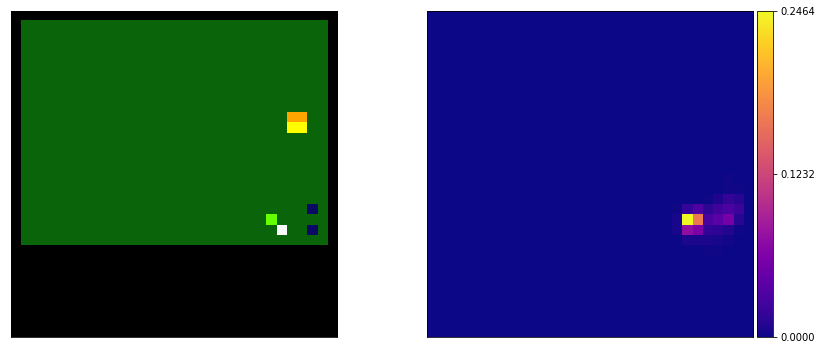


Step 42
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [28, 17]
Last click:  [26, 21]


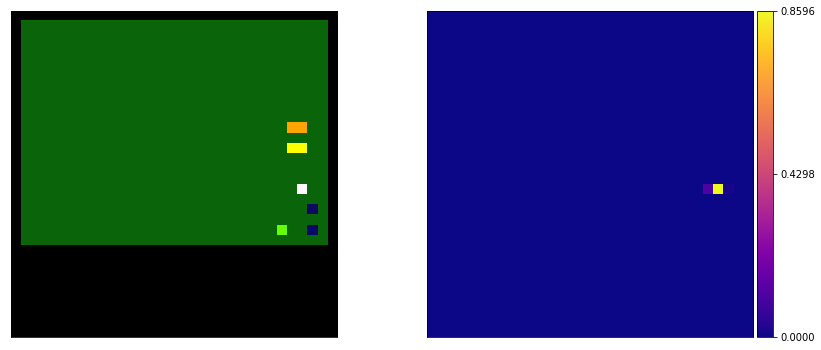


Step 43
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [27, 18]
Last click:  [28, 17]


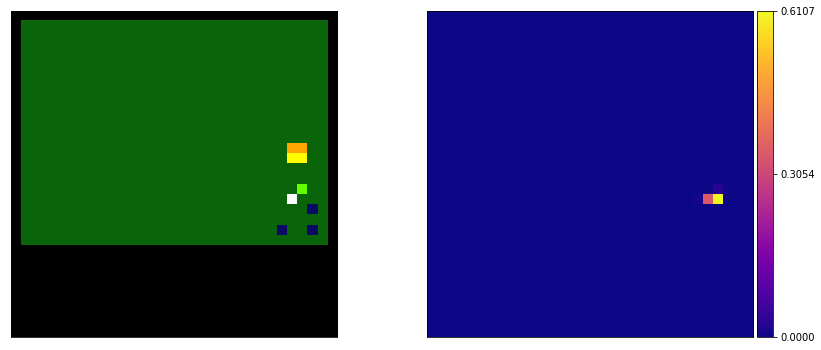


Step 44
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [28, 19]
Last click:  [27, 18]


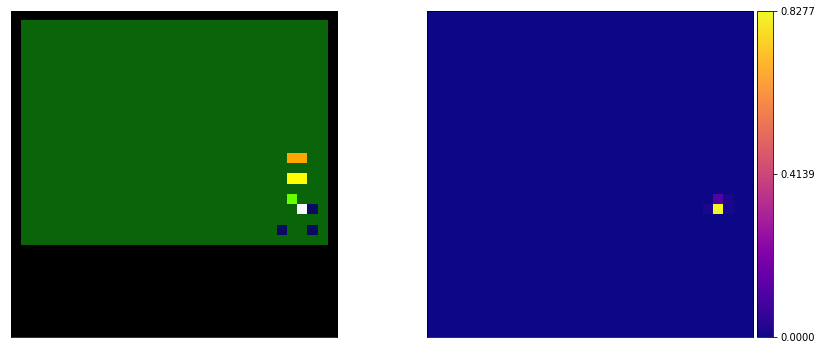


Step 45
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [28, 20]
Last click:  [28, 19]


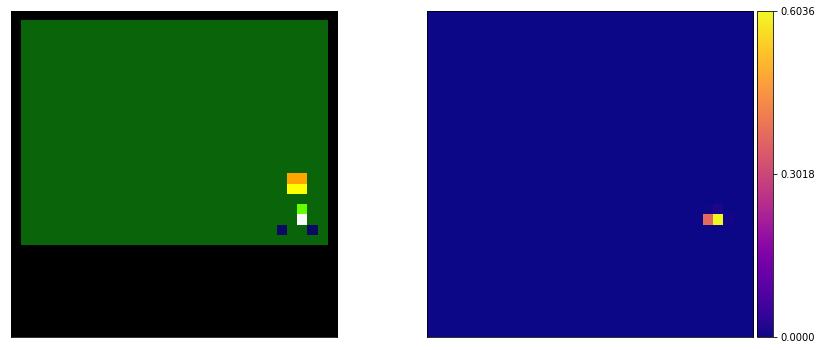


Step 46
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [27, 20]
Last click:  [28, 20]


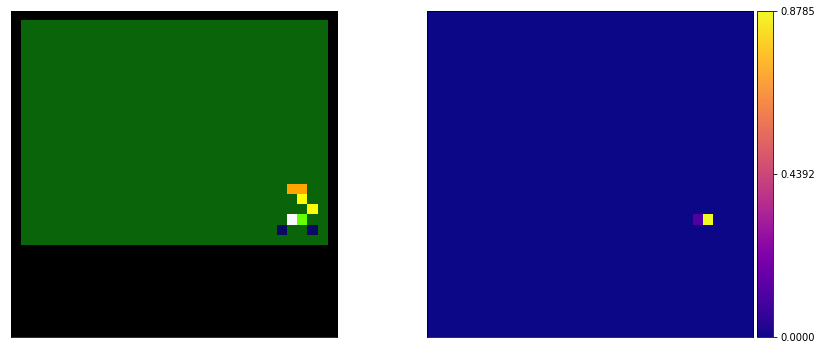


Step 47
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [24, 19]
Last click:  [27, 20]


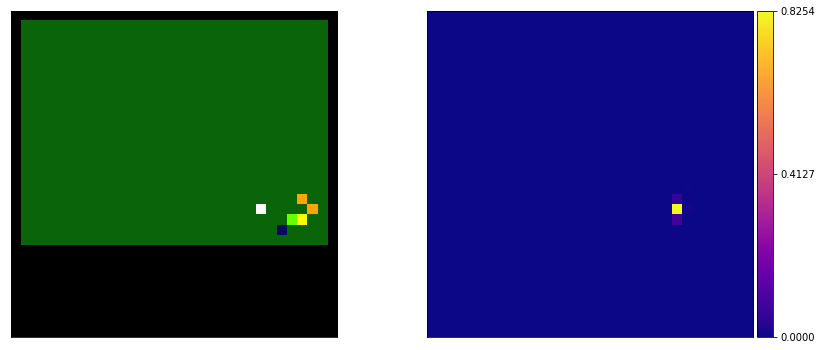


Step 48
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [22, 19]
Last click:  [24, 19]


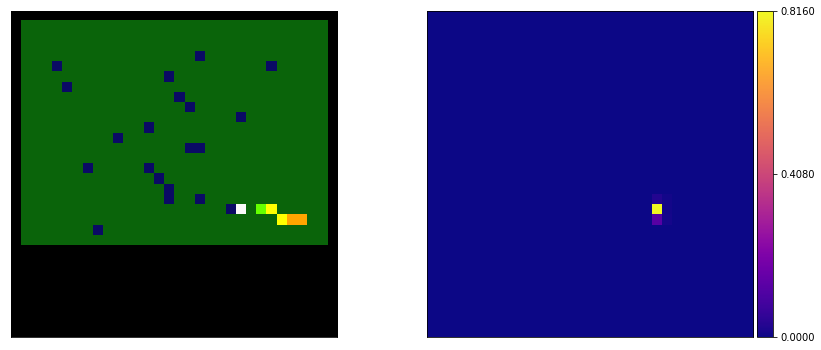


Step 49
Action no_op - prob: 0.00
Action select_army - prob: 0.00
Action Attack_screen - prob: 0.00
Action Move_screen - prob: 1.00
Action select_point - prob: 0.00
Action select_rect - prob: 0.00
-----------------------------------
Action chosen:  Move_screen
Click:  [22, 18]
Last click:  [22, 19]


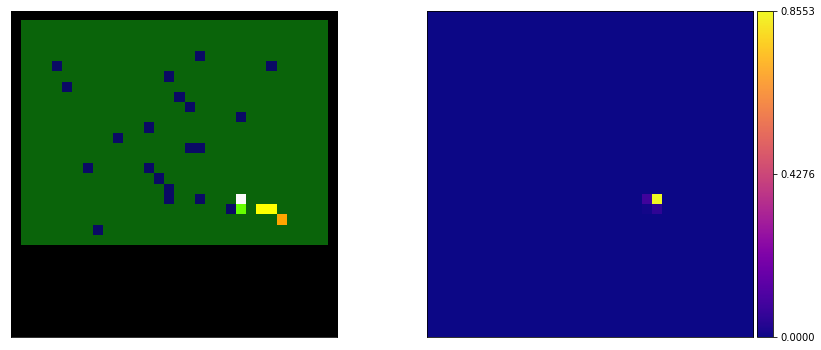

In [22]:
#for t in range(len(insp_dict['state_traj'])):
for t in range(50):
    print_action_info(inspector, insp_dict, t)
    plot_screen_and_decision(insp_dict, layer_names, t)